In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Concatenate, Multiply
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

2024-10-15 13:33:09.379212: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the dataset
data = pd.read_csv('./changhua_data.csv')

# Extract columns
# Assume: First column is time, second column is flow, third to ninth are rainfall data
times = pd.to_datetime(data.iloc[:, 0].values)  # Convert time to datetime
flows = data.iloc[:, 1].values.reshape(-1, 1)
rainfalls = data.iloc[:, 2:].values

# Create sequences for time-series prediction
def create_sequences(data, target, input_steps, output_steps):
    X, y, times_seq = [], [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:(i + input_steps), :])
        y.append(target[(i + input_steps):(i + input_steps + output_steps), 0])
        times_seq.append(times[i + input_steps:(i + input_steps + output_steps)])
    return np.array(X), np.array(y), np.array(times_seq)

input_steps = 12  # Use past 12 hours
output_steps = 6  # Predict next 6 hours

# Data preprocessing
scaler_flow = MinMaxScaler()
flows_scaled = scaler_flow.fit_transform(flows)

scaler_rainfall = MinMaxScaler()
rainfalls_scaled = scaler_rainfall.fit_transform(rainfalls)

# Combine rainfall and flow data for sequence creation
combined_data = np.concatenate((rainfalls_scaled, flows_scaled), axis=1)

# Create sequences
X, y, times_seq = create_sequences(combined_data, flows_scaled, input_steps, output_steps)

# Train-test split 不按照时间顺序分割
# X_train, X_test, y_train, y_test, times_train, times_test = train_test_split(X, y, times_seq, test_size=0.2, random_state=42)

# Train-test split using time-based split to maintain sequence continuity 按照时间顺序分割
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
times_train, times_test = times_seq[:split_index], times_seq[split_index:]

In [3]:
# DeepONet implementation
# Branch Network: Takes the rainfall data as input
branch_input = Input(shape=(input_steps, X_train.shape[2] - 1), name='branch_input')
branch_lstm = LSTM(64, activation='relu')(branch_input)
branch_output = Dense(32, activation='relu')(branch_lstm)

# Trunk Network: Takes the flow data as input
trunk_input = Input(shape=(input_steps, 1), name='trunk_input')
trunk_lstm = LSTM(64, activation='relu')(trunk_input)
trunk_output = Dense(32, activation='relu')(trunk_lstm)

# Replace pointwise multiplication with FNO and GRU layers
# Fourier Neural Operator (FNO) layer
from tensorflow.keras.layers import Conv1D, LayerNormalization

fno_layer_1 = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(branch_output[:, None, :])
fno_layer_2 = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(fno_layer_1)
fno_layer_2 = tf.squeeze(fno_layer_2, axis=1)

# GRU layers
gru_layer_1 = LSTM(32, return_sequences=True, activation='relu')(tf.expand_dims(fno_layer_2, axis=1))
gru_layer_2 = LSTM(32, activation='relu')(gru_layer_1)

# Combine FNO and GRU output
combined = Multiply()([trunk_output, gru_layer_2])
combined_output = Dense(output_steps, activation='linear')(combined)

# Model definition
model = Model(inputs=[branch_input, trunk_input], outputs=combined_output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Training the model
history = model.fit([X_train[:, :, :-1], X_train[:, :, -1:]], y_train, epochs=100, batch_size=16, validation_split=0.1)

# Evaluate the model
evaluation = model.evaluate([X_test[:, :, :-1], X_test[:, :, -1:]], y_test)
print(f'Test Loss: {evaluation[0]}, Test MAE: {evaluation[1]}')

# Make predictions
predictions = model.predict([X_test[:, :, :-1], X_test[:, :, -1:]])

# Only keep the first future step predictions to avoid overlap
predictions = predictions[:, 0].reshape(-1, 1)
y_test = y_test[:, 0].reshape(-1, 1)

# Inverse transform the predicted flows to original scale
predicted_flows = scaler_flow.inverse_transform(predictions)
y_test_inverse = scaler_flow.inverse_transform(y_test)
y_test_inverse = scaler_flow.inverse_transform(y_test)

# Display predictions
results = pd.DataFrame({'Actual Flow': y_test_inverse.flatten(), 'Predicted Flow': predicted_flows.flatten()})
print(results.head())

Epoch 1/100
421/421 [==============================] - 8s 8ms/step - loss: 0.0084 - mae: 0.0488 - val_loss: 4.7869e-04 - val_mae: 0.0146
Epoch 2/100
421/421 [==============================] - 3s 7ms/step - loss: 0.0025 - mae: 0.0235 - val_loss: 1.8413e-04 - val_mae: 0.0082
Epoch 3/100
421/421 [==============================] - 3s 7ms/step - loss: 0.0021 - mae: 0.0209 - val_loss: 2.9031e-04 - val_mae: 0.0096
Epoch 4/100
421/421 [==============================] - 3s 7ms/step - loss: 0.0019 - mae: 0.0200 - val_loss: 3.6717e-04 - val_mae: 0.0092
Epoch 5/100
421/421 [==============================] - 3s 7ms/step - loss: 0.0015 - mae: 0.0168 - val_loss: 3.1418e-04 - val_mae: 0.0105
Epoch 6/100
421/421 [==============================] - 3s 7ms/step - loss: 0.0014 - mae: 0.0169 - val_loss: 7.3693e-04 - val_mae: 0.0172
Epoch 7/100
421/421 [==============================] - 3s 7ms/step - loss: 0.0014 - mae: 0.0171 - val_loss: 1.4505e-04 - val_mae: 0.0069
Epoch 8/100
421/421 [====================

MAE: 20.703165890516797, MAPE: 0.284005916752325, R^2: 0.9547400095884452


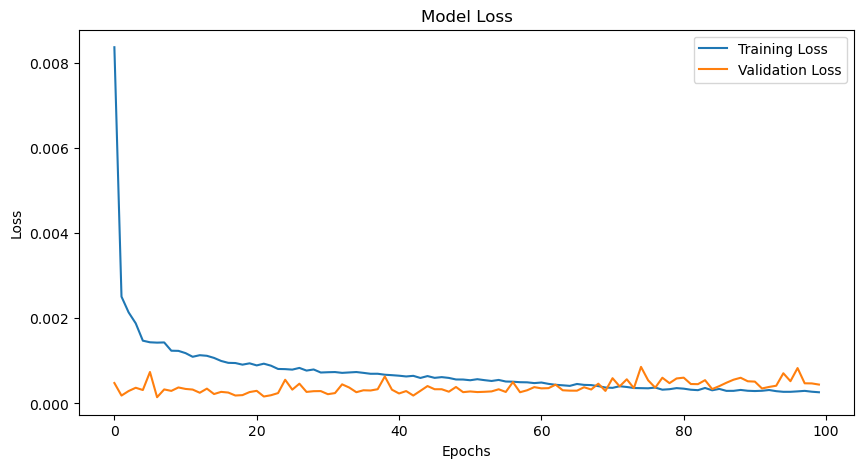

In [4]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test_inverse.flatten(), predicted_flows.flatten())
mape = mean_absolute_percentage_error(y_test_inverse.flatten(), predicted_flows.flatten())
r2 = r2_score(y_test_inverse.flatten(), predicted_flows.flatten())
print(f'MAE: {mae}, MAPE: {mape}, R^2: {r2}')

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

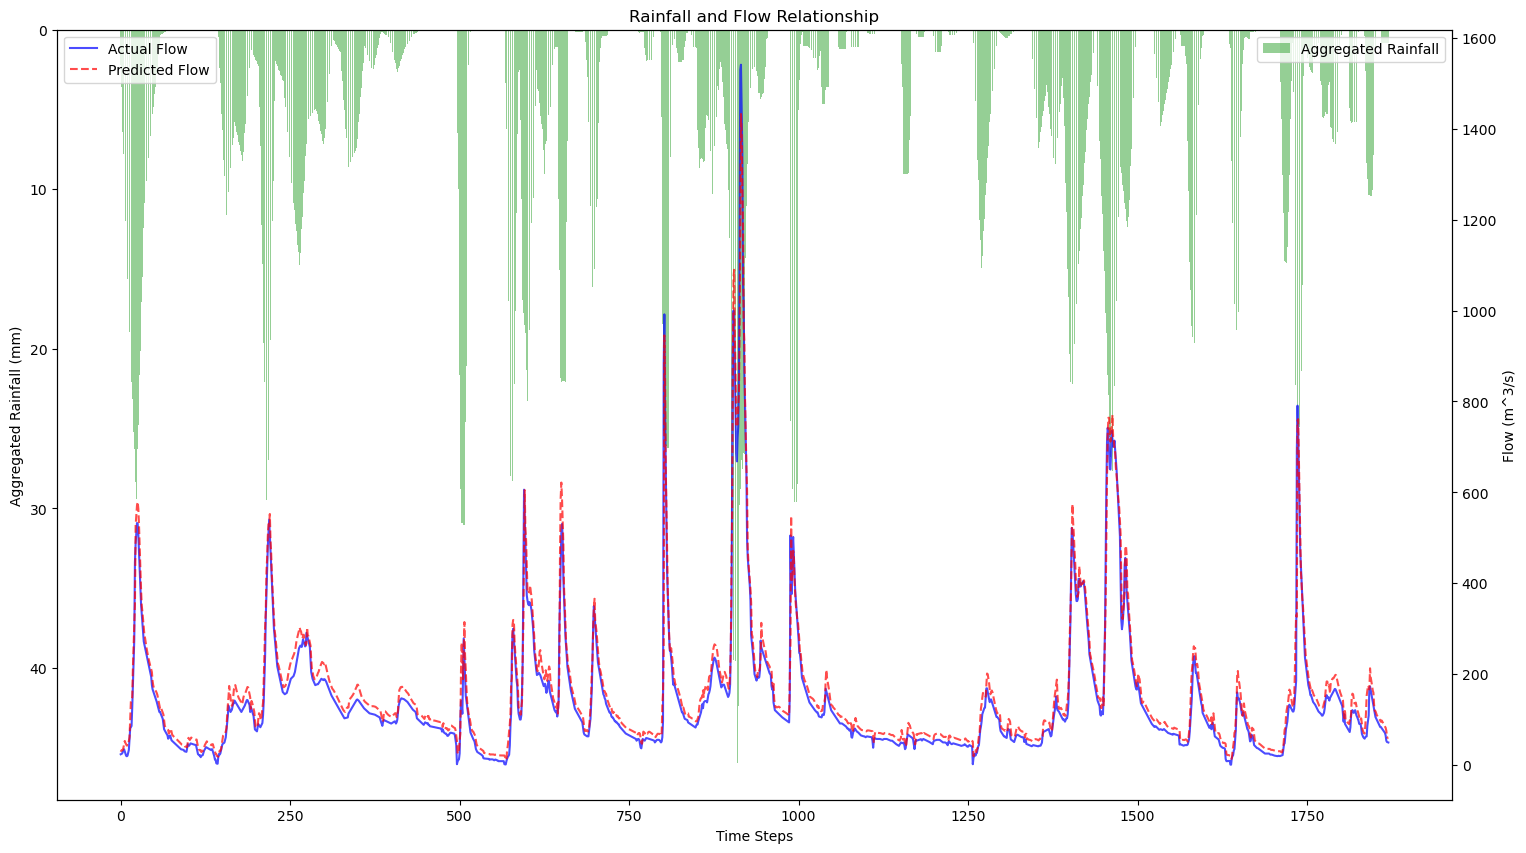

In [5]:
# Plot rainfall-flow dual-axis chart for actual vs predicted flows along with aggregated rainfall
fig, ax1 = plt.subplots(figsize=(18, 10))
draw_len = len(y_test_inverse)

# Use first 100 data points for plotting
time_steps = np.arange(draw_len)
aggregated_rainfall = scaler_rainfall.inverse_transform(X_test[:draw_len, :, :-1].reshape(-1, X_test.shape[2] - 1)).sum(axis=1).reshape(draw_len, -1).mean(axis=1)

# Plot aggregated rainfall as a bar chart, pointing downwards
ax1.bar(time_steps, aggregated_rainfall, color='tab:green', alpha=0.5, label='Aggregated Rainfall')
ax1.invert_yaxis()
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Aggregated Rainfall (mm)')
ax1.legend(loc='upper right')
ax1.set_title('Rainfall and Flow Relationship')

# Apply smoothing to actual and predicted flow
actual_flow = y_test_inverse[:draw_len, 0]
predicted_flow = predicted_flows[:draw_len, 0]

# Plot actual and predicted flow
ax2 = ax1.twinx() 
ax2.plot(time_steps, actual_flow, label='Actual Flow', color='blue', alpha=0.7)
ax2.plot(time_steps, predicted_flow, label='Predicted Flow', color='red', linestyle='dashed', alpha=0.7)

ax2.set_ylabel('Flow (m^3/s)')
ax2.legend(loc='upper left')

plt.show()

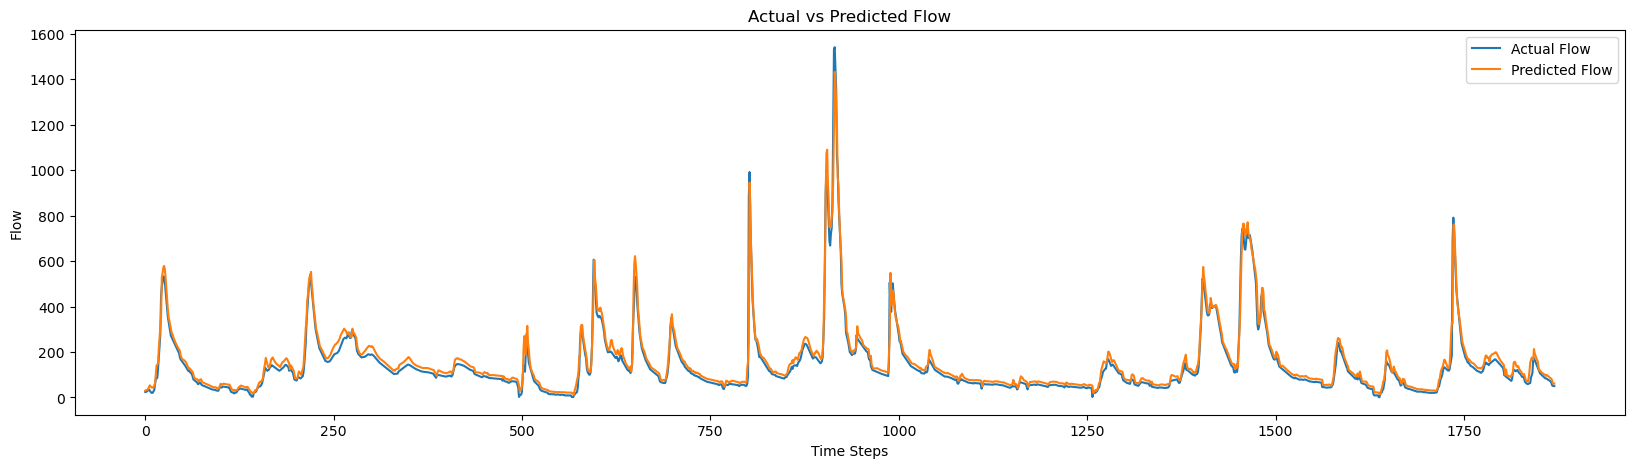

In [6]:
# Plot actual vs predicted flows 全部时间步
plt.figure(figsize=(20, 5))
plt.plot(y_test_inverse.flatten(), label='Actual Flow')
plt.plot(predicted_flows.flatten(), label='Predicted Flow')
plt.xlabel('Time Steps')
plt.ylabel('Flow')
plt.legend()
plt.title('Actual vs Predicted Flow')
plt.show()